In [ ]:
!gdown https://drive.google.com/uc?id=1ncmjIxMZGAD5sS96f18mskpRXKxH4QgZ
!unzip -qq template-matching.zip

Downloading...
From: https://drive.google.com/uc?id=1ncmjIxMZGAD5sS96f18mskpRXKxH4QgZ
To: /content/template-matching.zip
100% 682k/682k [00:00<00:00, 10.7MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import matplotlib.patches as patches

from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

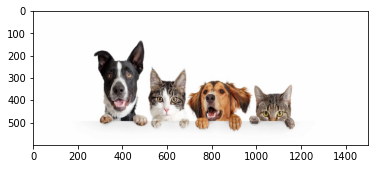

In [ ]:
PATH = '/content/template-matching/'
height = 600
width  = 1500

query = np.array(kimage.load_img(PATH+'image7.jpg', target_size=(height, width)))

plt.imshow(query)

In [ ]:
# get model 
model = tf.keras.applications.VGG16(include_top=True, 
                                    weights='imagenet', 
                                    input_shape=(224, 224, 3))

def compute_features(data):
    for i in range(1,19):
        data = model.layers[i](data)
    return data

def compute_prediction(data):
    for i in range(19, 23):
        data = model.layers[i](data)
    return data

553467904/553467096 [==============================] - 7s 0us/step


In [ ]:
# compute features
query_np = np.expand_dims(query, axis=0)
query_np = preprocess_input(query_np)

pred_query = compute_features(query_np)

In [ ]:
# compute predictions
height_fm = pred_query.shape[1]
width_fm  = pred_query.shape[2]

side = 7
scale = height // height_fm

prediction_data = []
for i in range(height_fm-side+1):
  for j in range(width_fm-side+1):
    patch = pred_query[:, i:i+side, j:j+side,:]
    patch = compute_prediction(patch)
    prediction_data.append( (tf.math.reduce_max(patch[0]).numpy(), 
                             i, j, 
                             tf.math.argmax(patch[0]).numpy()) )

tp_sorted = sorted(prediction_data, key=lambda item: item[0], reverse=True)

In [ ]:
labels = np.load(PATH+'imagenet1000_clsid_to_human.pkl', allow_pickle=True)

In [ ]:
def get_patch_query(query, i, j, side):
    query = np.array(query)
    points = [(i, j), (i+side, j), (i+side, j+side), (i, j+side)]
    stencil = np.zeros(query.shape).astype(query.dtype)
    contours = [np.array(points)]
    color = [255, 255, 255]
    cv2.fillPoly(stencil, contours, color)
    result = cv2.bitwise_and(query, stencil)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

def IoU(query, s_i, s_j, data):
    img1 = get_patch_query(query, data[s_i][1]*scale, data[s_i][2]*scale, side*scale)
    img2 = get_patch_query(query, data[s_j][1]*scale, data[s_j][2]*scale, side*scale)
    intersection = np.logical_and(img1, img2)
    union = np.logical_or(img1, img2)
    iou_score = np.sum(intersection) / (np.sum(union)+1e-8)
    return iou_score

# def remove_duplication(data):
#     result = []

#     length = len(data)
#     for k in tqdm(range(length-1)):
#         iou_score = IoU(query, data[k][1], data[k][2], data)
#         if (iou_score > 0.6 and data[k][0] > 0.5):
#             result.append(data[k])
    
#     return result

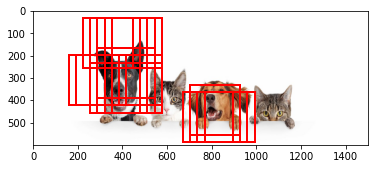

In [ ]:
# # Show all with a threshold
# im = kimage.load_img(PATH+'image7.jpg', target_size=(600, 1500))

# fig, ax = plt.subplots()
# ax.imshow(im)

# length = len(tp_sorted)

# # Create a Rectangle patch
# scale_height = height//height_fm
# scale_width  = width//width_fm
# for i in range(length): 
#   if (tp_sorted[i][0] > 0.6):
#     rect = patches.Rectangle((tp_sorted[i][2]*scale_width, tp_sorted[i][1]*scale_height), 
#                              224, 224, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

# plt.show()

100%|██████████| 479/479 [00:09<00:00, 47.90it/s]


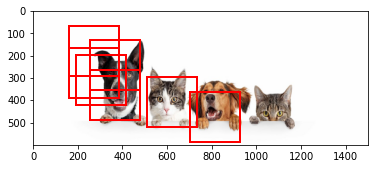

In [ ]:
# im = kimage.load_img(PATH+'image7.jpg', target_size=(600, 1500))

# fig, ax = plt.subplots()
# ax.imshow(im)

# result = remove_duplication(tp_sorted)
# length = len(result)

# # Create a Rectangle patch
# scale_height = height//height_fm
# scale_width  = width//width_fm
# for i in range(length):   
#   rect = patches.Rectangle((result[i][2]*scale_width, result[i][1]*scale_height), 
#                            224, 224, linewidth=2, edgecolor='r', facecolor='none')
#   ax.add_patch(rect)

# plt.show()